# Attention Diagnostics: (KL, Var) Phase Space for IOI Circuit

Computes two diagnostics for each attention head in GPT-2-small:
- **Normalized KL**: $\hat\rho_{\text{eff}} / \log n = (\log n - H(\hat\pi)) / \log n$
- **Normalized Var**: $\text{Var}_{\hat\pi}(\log \hat\pi) / (\log n)^2$

Tests against the IOI circuit from Wang et al. 2022.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer

torch.set_grad_enabled(False)

model = HookedTransformer.from_pretrained("gpt2-small")
print(f"Loaded: {model.cfg.n_layers} layers, {model.cfg.n_heads} heads/layer")

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer
Loaded: 12 layers, 12 heads/layer


## IOI Circuit Head Labels
From Wang et al. 2022 (arXiv:2211.00593)

In [2]:
# IOI circuit head labels: (layer, head)
IOI_HEADS = {
    "Name Mover": [(9, 6), (9, 9), (10, 0)],
    "Backup Name Mover": [(9, 0), (9, 7), (10, 1), (10, 2), (10, 6), (10, 10), (11, 2), (11, 9)],
    "Negative Name Mover": [(10, 7), (11, 10)],
    "S-Inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    "Induction": [(5, 5), (6, 9)],
    "Duplicate Token": [(0, 1), (3, 0)],
    "Previous Token": [(2, 2), (4, 11)],
}

# Flat set for quick lookup
ALL_CIRCUIT_HEADS = set()
for heads in IOI_HEADS.values():
    ALL_CIRCUIT_HEADS.update(heads)

def head_role(layer, head):
    """Return circuit role string, or 'Non-circuit' if not in IOI circuit."""
    for role, heads in IOI_HEADS.items():
        if (layer, head) in heads:
            return role
    return "Non-circuit"

print(f"Total circuit heads: {len(ALL_CIRCUIT_HEADS)}")
for role, heads in IOI_HEADS.items():
    print(f"  {role}: {heads}")

Total circuit heads: 23
  Name Mover: [(9, 6), (9, 9), (10, 0)]
  Backup Name Mover: [(9, 0), (9, 7), (10, 1), (10, 2), (10, 6), (10, 10), (11, 2), (11, 9)]
  Negative Name Mover: [(10, 7), (11, 10)]
  S-Inhibition: [(7, 3), (7, 9), (8, 6), (8, 10)]
  Induction: [(5, 5), (6, 9)]
  Duplicate Token: [(0, 1), (3, 0)]
  Previous Token: [(2, 2), (4, 11)]


## IOI Prompt Generation

In [3]:
import random

# IOI templates (ABBA and BABA patterns) — one name repeats as subject
TEMPLATES_ABBA = [
    "When {A} and {B} went to the store, {B} gave a drink to",
    "When {A} and {B} went to the park, {B} handed a ball to",
    "When {A} and {B} arrived at the office, {B} passed a note to",
    "When {A} and {B} got to the restaurant, {B} offered a menu to",
    "When {A} and {B} walked into the room, {B} showed a book to",
    "After {A} and {B} met at the cafe, {B} sent a message to",
    "After {A} and {B} sat down for dinner, {B} gave a gift to",
]

TEMPLATES_BABA = [
    "When {B} and {A} went to the store, {B} gave a drink to",
    "When {B} and {A} went to the park, {B} handed a ball to",
    "When {B} and {A} arrived at the office, {B} passed a note to",
    "When {B} and {A} got to the restaurant, {B} offered a menu to",
    "When {B} and {A} walked into the room, {B} showed a book to",
    "After {B} and {A} met at the cafe, {B} sent a message to",
    "After {B} and {A} sat down for dinner, {B} gave a gift to",
]

# Non-IOI controls: same structure, same length, but the subject of the second
# clause is a THIRD name C (not A or B). No name repeats → IOI circuit shouldn't fire.
TEMPLATES_NON_IOI = [
    "When {A} and {B} went to the store, {C} gave a drink to",
    "When {A} and {B} went to the park, {C} handed a ball to",
    "When {A} and {B} arrived at the office, {C} passed a note to",
    "When {A} and {B} got to the restaurant, {C} offered a menu to",
    "When {A} and {B} walked into the room, {C} showed a book to",
    "After {A} and {B} met at the cafe, {C} sent a message to",
    "After {A} and {B} sat down for dinner, {C} gave a gift to",
]

NAMES = [
    "Mary", "John", "Alice", "Bob", "Sarah", "Tom",
    "Emma", "James", "Lisa", "David", "Kate", "Mark",
]


def generate_unique_prompts_ioi(n, seed=42):
    """Generate n unique IOI prompts (one name repeats)."""
    random.seed(seed)
    templates = TEMPLATES_ABBA + TEMPLATES_BABA
    seen = set()
    prompts = []
    while len(prompts) < n:
        template = random.choice(templates)
        a, b = random.sample(NAMES, 2)
        prompt = template.format(A=a, B=b)
        if prompt not in seen:
            seen.add(prompt)
            prompts.append(prompt)
    return prompts


def generate_unique_prompts_non_ioi(n, seed=43):
    """Generate n unique non-IOI prompts (third name C, no repetition)."""
    random.seed(seed)
    seen = set()
    prompts = []
    while len(prompts) < n:
        template = random.choice(TEMPLATES_NON_IOI)
        a, b, c = random.sample(NAMES, 3)
        prompt = template.format(A=a, B=b, C=c)
        if prompt not in seen:
            seen.add(prompt)
            prompts.append(prompt)
    return prompts


ioi_prompts = generate_unique_prompts_ioi(50)
non_ioi_prompts = generate_unique_prompts_non_ioi(50)

assert len(set(ioi_prompts)) == 50, "IOI prompts have duplicates!"
assert len(set(non_ioi_prompts)) == 50, "Non-IOI prompts have duplicates!"

print(f"IOI prompts: {len(ioi_prompts)} (all unique)")
for i in range(3):
    print(f"  {ioi_prompts[i]}")
print(f"\nNon-IOI prompts: {len(non_ioi_prompts)} (all unique)")
for i in range(3):
    print(f"  {non_ioi_prompts[i]}")

# Verify lengths match
ioi_lens = [model.to_tokens(p).shape[1] for p in ioi_prompts]
non_ioi_lens = [model.to_tokens(p).shape[1] for p in non_ioi_prompts]
print(f"\nToken lengths — IOI: {min(ioi_lens)}-{max(ioi_lens)} (mean {np.mean(ioi_lens):.1f}), "
      f"Non-IOI: {min(non_ioi_lens)}-{max(non_ioi_lens)} (mean {np.mean(non_ioi_lens):.1f})")

IOI prompts: 50 (all unique)
  When Mary and John got to the restaurant, Mary offered a menu to
  When Bob and Sarah walked into the room, Bob showed a book to
  When Alice and John got to the restaurant, John offered a menu to

Non-IOI prompts: 50 (all unique)
  When Sarah and Alice went to the store, James gave a drink to
  When Kate and John arrived at the office, James passed a note to
  When James and David walked into the room, Mary showed a book to

Token lengths — IOI: 15-15 (mean 15.0), Non-IOI: 15-15 (mean 15.0)


## Diagnostic Computation

In [4]:
def compute_diagnostics(model, prompts):
    """
    For each prompt, compute normalized KL and normalized Var for all heads
    at the final token position.
    
    Returns:
        kl: (n_prompts, n_layers, n_heads)
        var: (n_prompts, n_layers, n_heads)
    """
    n_layers = model.cfg.n_layers
    n_heads = model.cfg.n_heads
    n_prompts = len(prompts)
    
    kl_all = np.zeros((n_prompts, n_layers, n_heads))
    var_all = np.zeros((n_prompts, n_layers, n_heads))
    
    for p_idx, prompt in enumerate(prompts):
        tokens = model.to_tokens(prompt)  # (1, seq_len)
        _, cache = model.run_with_cache(tokens)
        
        seq_len = tokens.shape[1]
        log_n = np.log(seq_len)
        
        for layer in range(n_layers):
            # attention pattern: (1, n_heads, seq_len, seq_len)
            attn = cache["pattern", layer]  # (1, n_heads, dest, src)
            # Take final token's attention over all source positions
            pi = attn[0, :, -1, :]  # (n_heads, seq_len)
            
            log_pi = torch.log(pi + 1e-12)
            
            # H(pi) = -sum pi * log pi
            entropy = -(pi * log_pi).sum(dim=-1)  # (n_heads,)
            
            # KL(pi || u) = log n - H(pi), normalized by log n
            kl_norm = (log_n - entropy.cpu().numpy()) / log_n
            
            # Var_pi(log pi), normalized by (log n)^2
            mean_log_pi = (pi * log_pi).sum(dim=-1, keepdim=True)  # (n_heads, 1)
            var_log_pi = (pi * (log_pi - mean_log_pi) ** 2).sum(dim=-1)  # (n_heads,)
            var_norm = var_log_pi.cpu().numpy() / (log_n ** 2)
            
            kl_all[p_idx, layer, :] = kl_norm
            var_all[p_idx, layer, :] = var_norm
    
    return kl_all, var_all


print("Computing diagnostics on IOI prompts...")
kl_ioi, var_ioi = compute_diagnostics(model, ioi_prompts)
print(f"  Shape: {kl_ioi.shape}")

print("Computing diagnostics on non-IOI prompts...")
kl_non_ioi, var_non_ioi = compute_diagnostics(model, non_ioi_prompts)
print(f"  Shape: {kl_non_ioi.shape}")

print("Done!")

Computing diagnostics on IOI prompts...


  Shape: (50, 12, 12)
Computing diagnostics on non-IOI prompts...


  Shape: (50, 12, 12)
Done!


## Figure 1: One Circuit Head vs One Non-Circuit Head (IOI prompts)

Name Mover (9, 9) vs a non-circuit head.

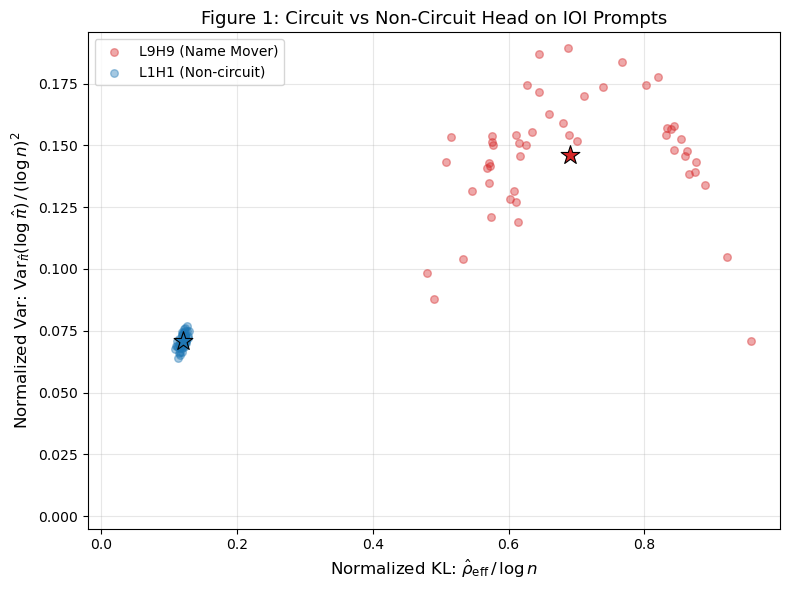

In [5]:
# Pick heads
circuit_head = (9, 9)   # Name Mover
non_circuit_head = (1, 1)  # Not in any IOI circuit component

# Verify
assert circuit_head in ALL_CIRCUIT_HEADS
assert non_circuit_head not in ALL_CIRCUIT_HEADS

# Extract per-prompt values
kl_circuit = kl_ioi[:, circuit_head[0], circuit_head[1]]
var_circuit = var_ioi[:, circuit_head[0], circuit_head[1]]
kl_noncircuit = kl_ioi[:, non_circuit_head[0], non_circuit_head[1]]
var_noncircuit = var_ioi[:, non_circuit_head[0], non_circuit_head[1]]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(kl_circuit, var_circuit, alpha=0.4, s=30, c="#d62728",
           label=f"L{circuit_head[0]}H{circuit_head[1]} (Name Mover)", zorder=2)
ax.scatter(kl_noncircuit, var_noncircuit, alpha=0.4, s=30, c="#1f77b4",
           label=f"L{non_circuit_head[0]}H{non_circuit_head[1]} (Non-circuit)", zorder=2)

# Averages as larger markers
ax.scatter(kl_circuit.mean(), var_circuit.mean(), s=200, c="#d62728",
           marker="*", edgecolors="black", linewidths=0.8, zorder=3)
ax.scatter(kl_noncircuit.mean(), var_noncircuit.mean(), s=200, c="#1f77b4",
           marker="*", edgecolors="black", linewidths=0.8, zorder=3)

ax.set_xlabel(r"Normalized KL: $\hat{\rho}_{\mathrm{eff}} \,/\, \log n$", fontsize=12)
ax.set_ylabel(r"Normalized Var: $\mathrm{Var}_{\hat{\pi}}(\log \hat{\pi}) \,/\, (\log n)^2$", fontsize=12)
ax.set_title("Figure 1: Circuit vs Non-Circuit Head on IOI Prompts", fontsize=13)
ax.legend(fontsize=10)
ax.set_xlim(left=-0.02)
ax.set_ylim(bottom=-0.005)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("fig1_circuit_vs_noncircuit.png", dpi=150, bbox_inches="tight")
plt.show()

## Figure 2: Circuit Head — Activating vs Non-Activating Prompts

Same Name Mover (9, 9): IOI prompts vs non-IOI prompts.

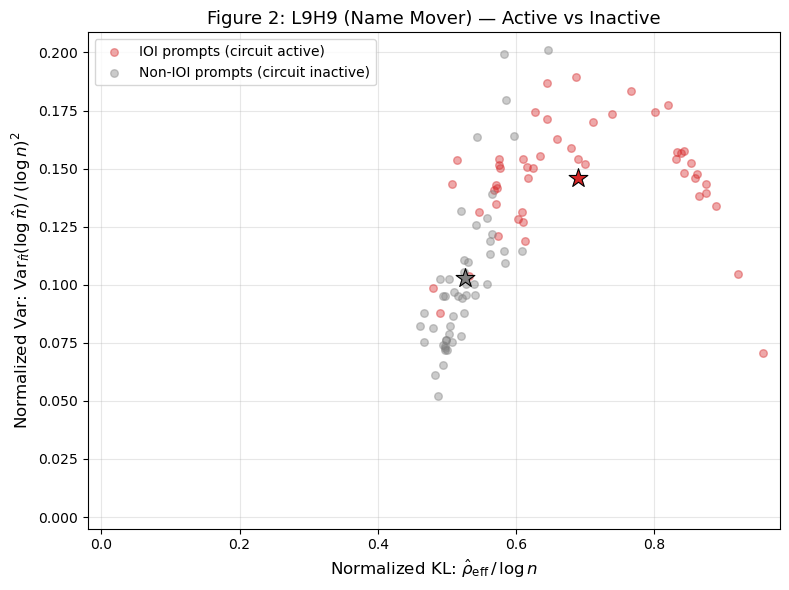

In [6]:
l, h = circuit_head

kl_active = kl_ioi[:, l, h]
var_active = var_ioi[:, l, h]
kl_inactive = kl_non_ioi[:, l, h]
var_inactive = var_non_ioi[:, l, h]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(kl_active, var_active, alpha=0.4, s=30, c="#d62728",
           label="IOI prompts (circuit active)", zorder=2)
ax.scatter(kl_inactive, var_inactive, alpha=0.4, s=30, c="#7f7f7f",
           label="Non-IOI prompts (circuit inactive)", zorder=2)

# Averages
ax.scatter(kl_active.mean(), var_active.mean(), s=200, c="#d62728",
           marker="*", edgecolors="black", linewidths=0.8, zorder=3)
ax.scatter(kl_inactive.mean(), var_inactive.mean(), s=200, c="#7f7f7f",
           marker="*", edgecolors="black", linewidths=0.8, zorder=3)

ax.set_xlabel(r"Normalized KL: $\hat{\rho}_{\mathrm{eff}} \,/\, \log n$", fontsize=12)
ax.set_ylabel(r"Normalized Var: $\mathrm{Var}_{\hat{\pi}}(\log \hat{\pi}) \,/\, (\log n)^2$", fontsize=12)
ax.set_title(f"Figure 2: L{l}H{h} (Name Mover) — Active vs Inactive", fontsize=13)
ax.legend(fontsize=10)
ax.set_xlim(left=-0.02)
ax.set_ylim(bottom=-0.005)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("fig2_active_vs_inactive.png", dpi=150, bbox_inches="tight")
plt.show()

## Figure 2b: Active vs Inactive — Grid Across Many Heads

Same comparison as Fig 2, but for a selection of circuit heads (various roles) and non-circuit heads.

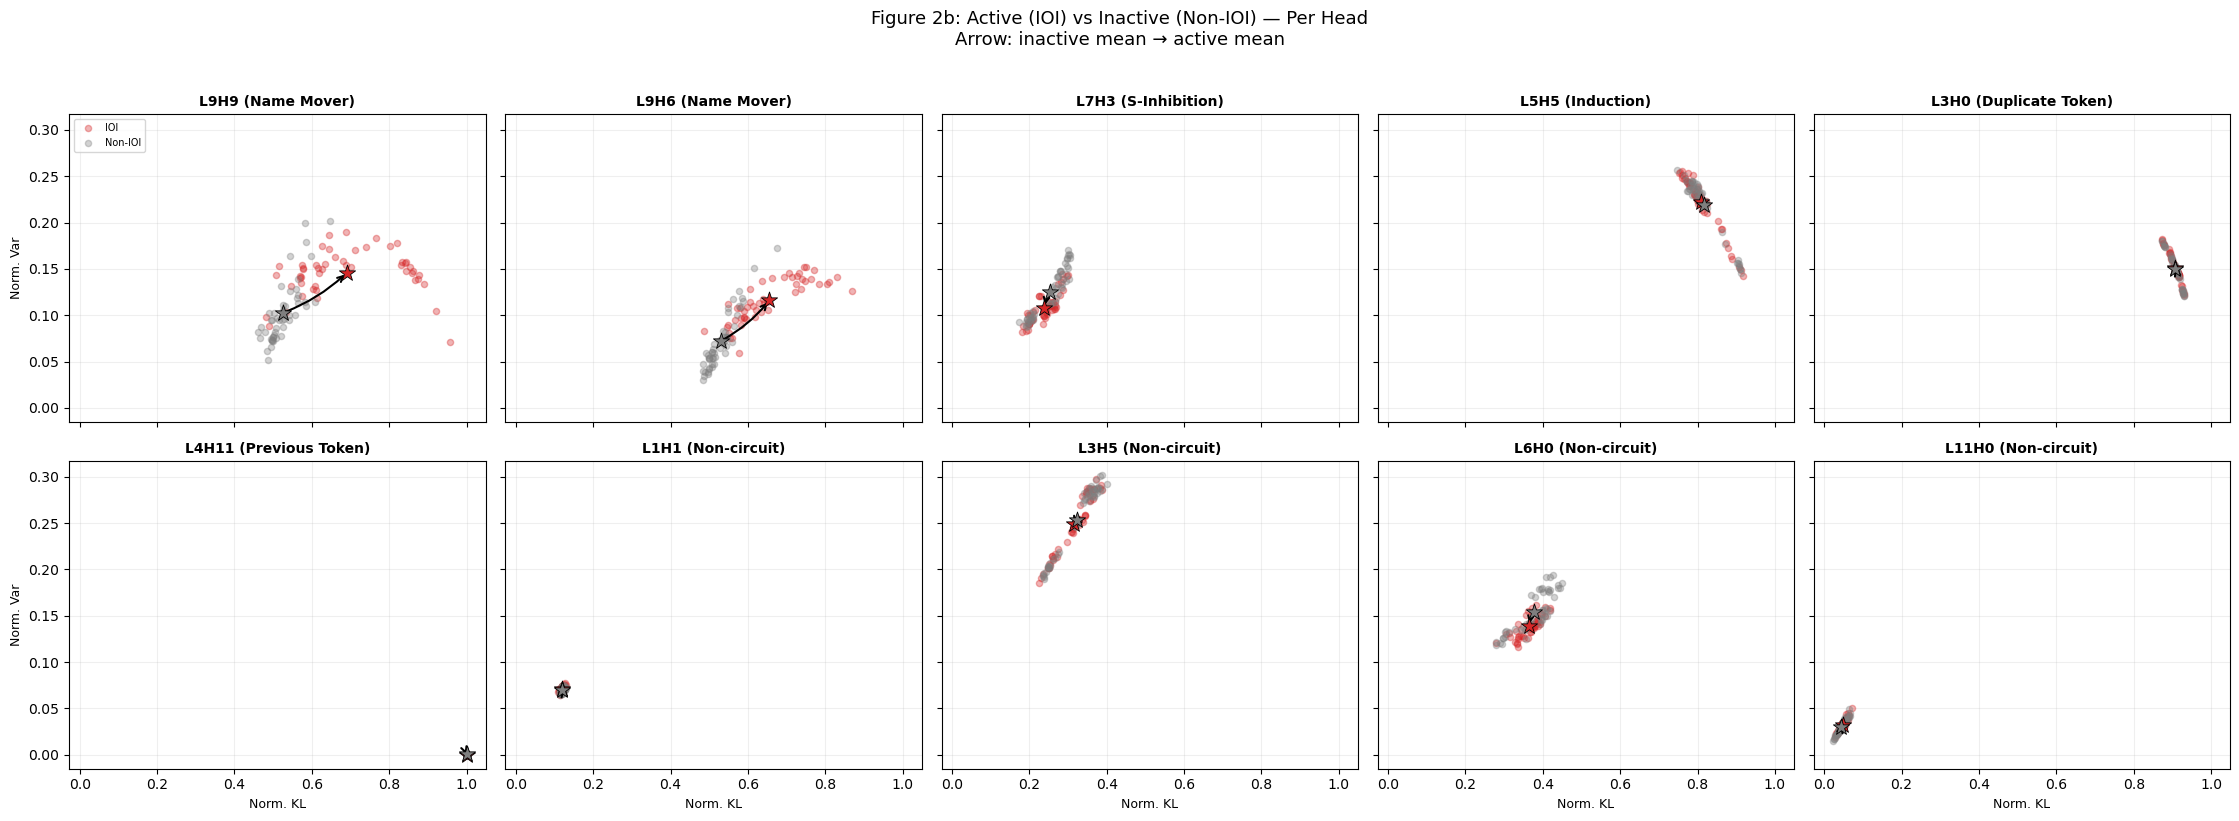

In [7]:
# Heads to compare: one per circuit role + a few non-circuit heads
HEADS_TO_PLOT = [
    # Circuit heads (one per role)
    ((9, 9),  "Name Mover"),
    ((9, 6),  "Name Mover"),
    ((7, 3),  "S-Inhibition"),
    ((5, 5),  "Induction"),
    ((3, 0),  "Duplicate Token"),
    ((4, 11), "Previous Token"),
    # Non-circuit heads (spread across layers)
    ((1, 1),  "Non-circuit"),
    ((3, 5),  "Non-circuit"),
    ((6, 0),  "Non-circuit"),
    ((11, 0), "Non-circuit"),
]

n_heads_plot = len(HEADS_TO_PLOT)
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 4 * nrows),
                          sharex=True, sharey=True)
axes = axes.flatten()

for idx, ((l, h), role) in enumerate(HEADS_TO_PLOT):
    ax = axes[idx]

    kl_active = kl_ioi[:, l, h]
    var_active = var_ioi[:, l, h]
    kl_inactive = kl_non_ioi[:, l, h]
    var_inactive = var_non_ioi[:, l, h]

    ax.scatter(kl_active, var_active, alpha=0.35, s=20, c="#d62728",
               label="IOI", zorder=2)
    ax.scatter(kl_inactive, var_inactive, alpha=0.35, s=20, c="#7f7f7f",
               label="Non-IOI", zorder=2)

    # Averages with arrows from inactive mean to active mean
    mean_active = (kl_active.mean(), var_active.mean())
    mean_inactive = (kl_inactive.mean(), var_inactive.mean())

    ax.scatter(*mean_active, s=150, c="#d62728", marker="*",
               edgecolors="black", linewidths=0.6, zorder=4)
    ax.scatter(*mean_inactive, s=150, c="#7f7f7f", marker="*",
               edgecolors="black", linewidths=0.6, zorder=4)

    # Arrow from inactive mean to active mean
    ax.annotate("", xy=mean_active, xytext=mean_inactive,
                arrowprops=dict(arrowstyle="->", color="black",
                                lw=1.5, connectionstyle="arc3,rad=0.1"),
                zorder=3)

    in_circuit = "IOI" if (l, h) in ALL_CIRCUIT_HEADS else "non"
    ax.set_title(f"L{l}H{h} ({role})", fontsize=10, fontweight="bold")
    ax.grid(True, alpha=0.2)

    if idx == 0:
        ax.legend(fontsize=7, loc="upper left")

# Shared axis labels
for ax in axes[ncols:]:
    ax.set_xlabel(r"Norm. KL", fontsize=9)
for ax in axes[::ncols]:
    ax.set_ylabel(r"Norm. Var", fontsize=9)

fig.suptitle("Figure 2b: Active (IOI) vs Inactive (Non-IOI) — Per Head\n"
             "Arrow: inactive mean → active mean",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig("fig2b_grid_active_inactive.png", dpi=150, bbox_inches="tight")
plt.show()

## Figure 2c: All S-Inhibition Heads — Does Var consistently drop on activation?

L7H3 was the only circuit head in 2b where Var went *down* on activation. Check whether this is an S-Inhibition trait or specific to that head.

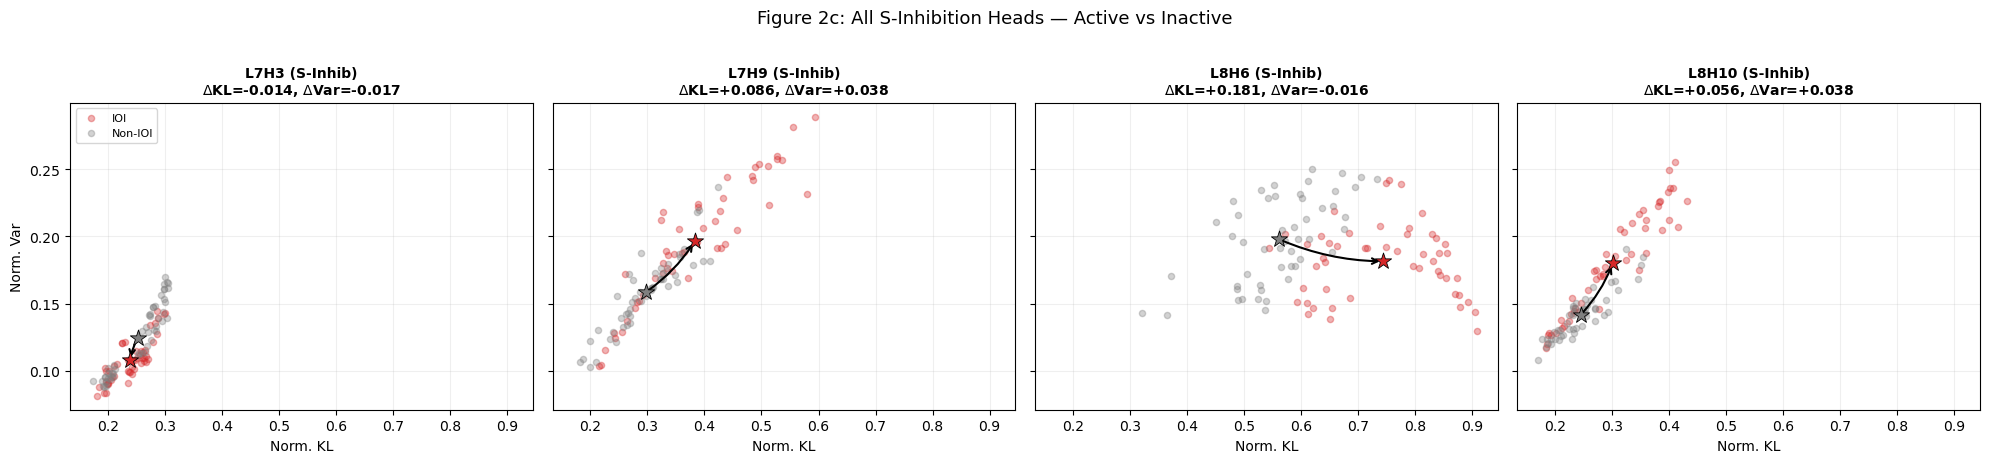

In [8]:
S_INHIBITION_HEADS = [(7, 3), (7, 9), (8, 6), (8, 10)]

fig, axes = plt.subplots(1, 4, figsize=(5 * 4, 4.5), sharex=True, sharey=True)

for idx, (l, h) in enumerate(S_INHIBITION_HEADS):
    ax = axes[idx]

    kl_active = kl_ioi[:, l, h]
    var_active = var_ioi[:, l, h]
    kl_inactive = kl_non_ioi[:, l, h]
    var_inactive = var_non_ioi[:, l, h]

    ax.scatter(kl_active, var_active, alpha=0.35, s=20, c="#d62728",
               label="IOI", zorder=2)
    ax.scatter(kl_inactive, var_inactive, alpha=0.35, s=20, c="#7f7f7f",
               label="Non-IOI", zorder=2)

    mean_active = (kl_active.mean(), var_active.mean())
    mean_inactive = (kl_inactive.mean(), var_inactive.mean())

    ax.scatter(*mean_active, s=150, c="#d62728", marker="*",
               edgecolors="black", linewidths=0.6, zorder=4)
    ax.scatter(*mean_inactive, s=150, c="#7f7f7f", marker="*",
               edgecolors="black", linewidths=0.6, zorder=4)

    ax.annotate("", xy=mean_active, xytext=mean_inactive,
                arrowprops=dict(arrowstyle="->", color="black",
                                lw=1.5, connectionstyle="arc3,rad=0.1"),
                zorder=3)

    # Print delta for quick reading
    dkl = mean_active[0] - mean_inactive[0]
    dvar = mean_active[1] - mean_inactive[1]
    ax.set_title(f"L{l}H{h} (S-Inhib)\n"
                 f"$\\Delta$KL={dkl:+.3f}, $\\Delta$Var={dvar:+.3f}",
                 fontsize=10, fontweight="bold")
    ax.grid(True, alpha=0.2)

    if idx == 0:
        ax.legend(fontsize=8, loc="upper left")
        ax.set_ylabel(r"Norm. Var", fontsize=10)

axes[0].set_xlabel(r"Norm. KL", fontsize=10)
axes[1].set_xlabel(r"Norm. KL", fontsize=10)
axes[2].set_xlabel(r"Norm. KL", fontsize=10)
axes[3].set_xlabel(r"Norm. KL", fontsize=10)

fig.suptitle("Figure 2c: All S-Inhibition Heads — Active vs Inactive",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig("fig2c_s_inhibition.png", dpi=150, bbox_inches="tight")
plt.show()

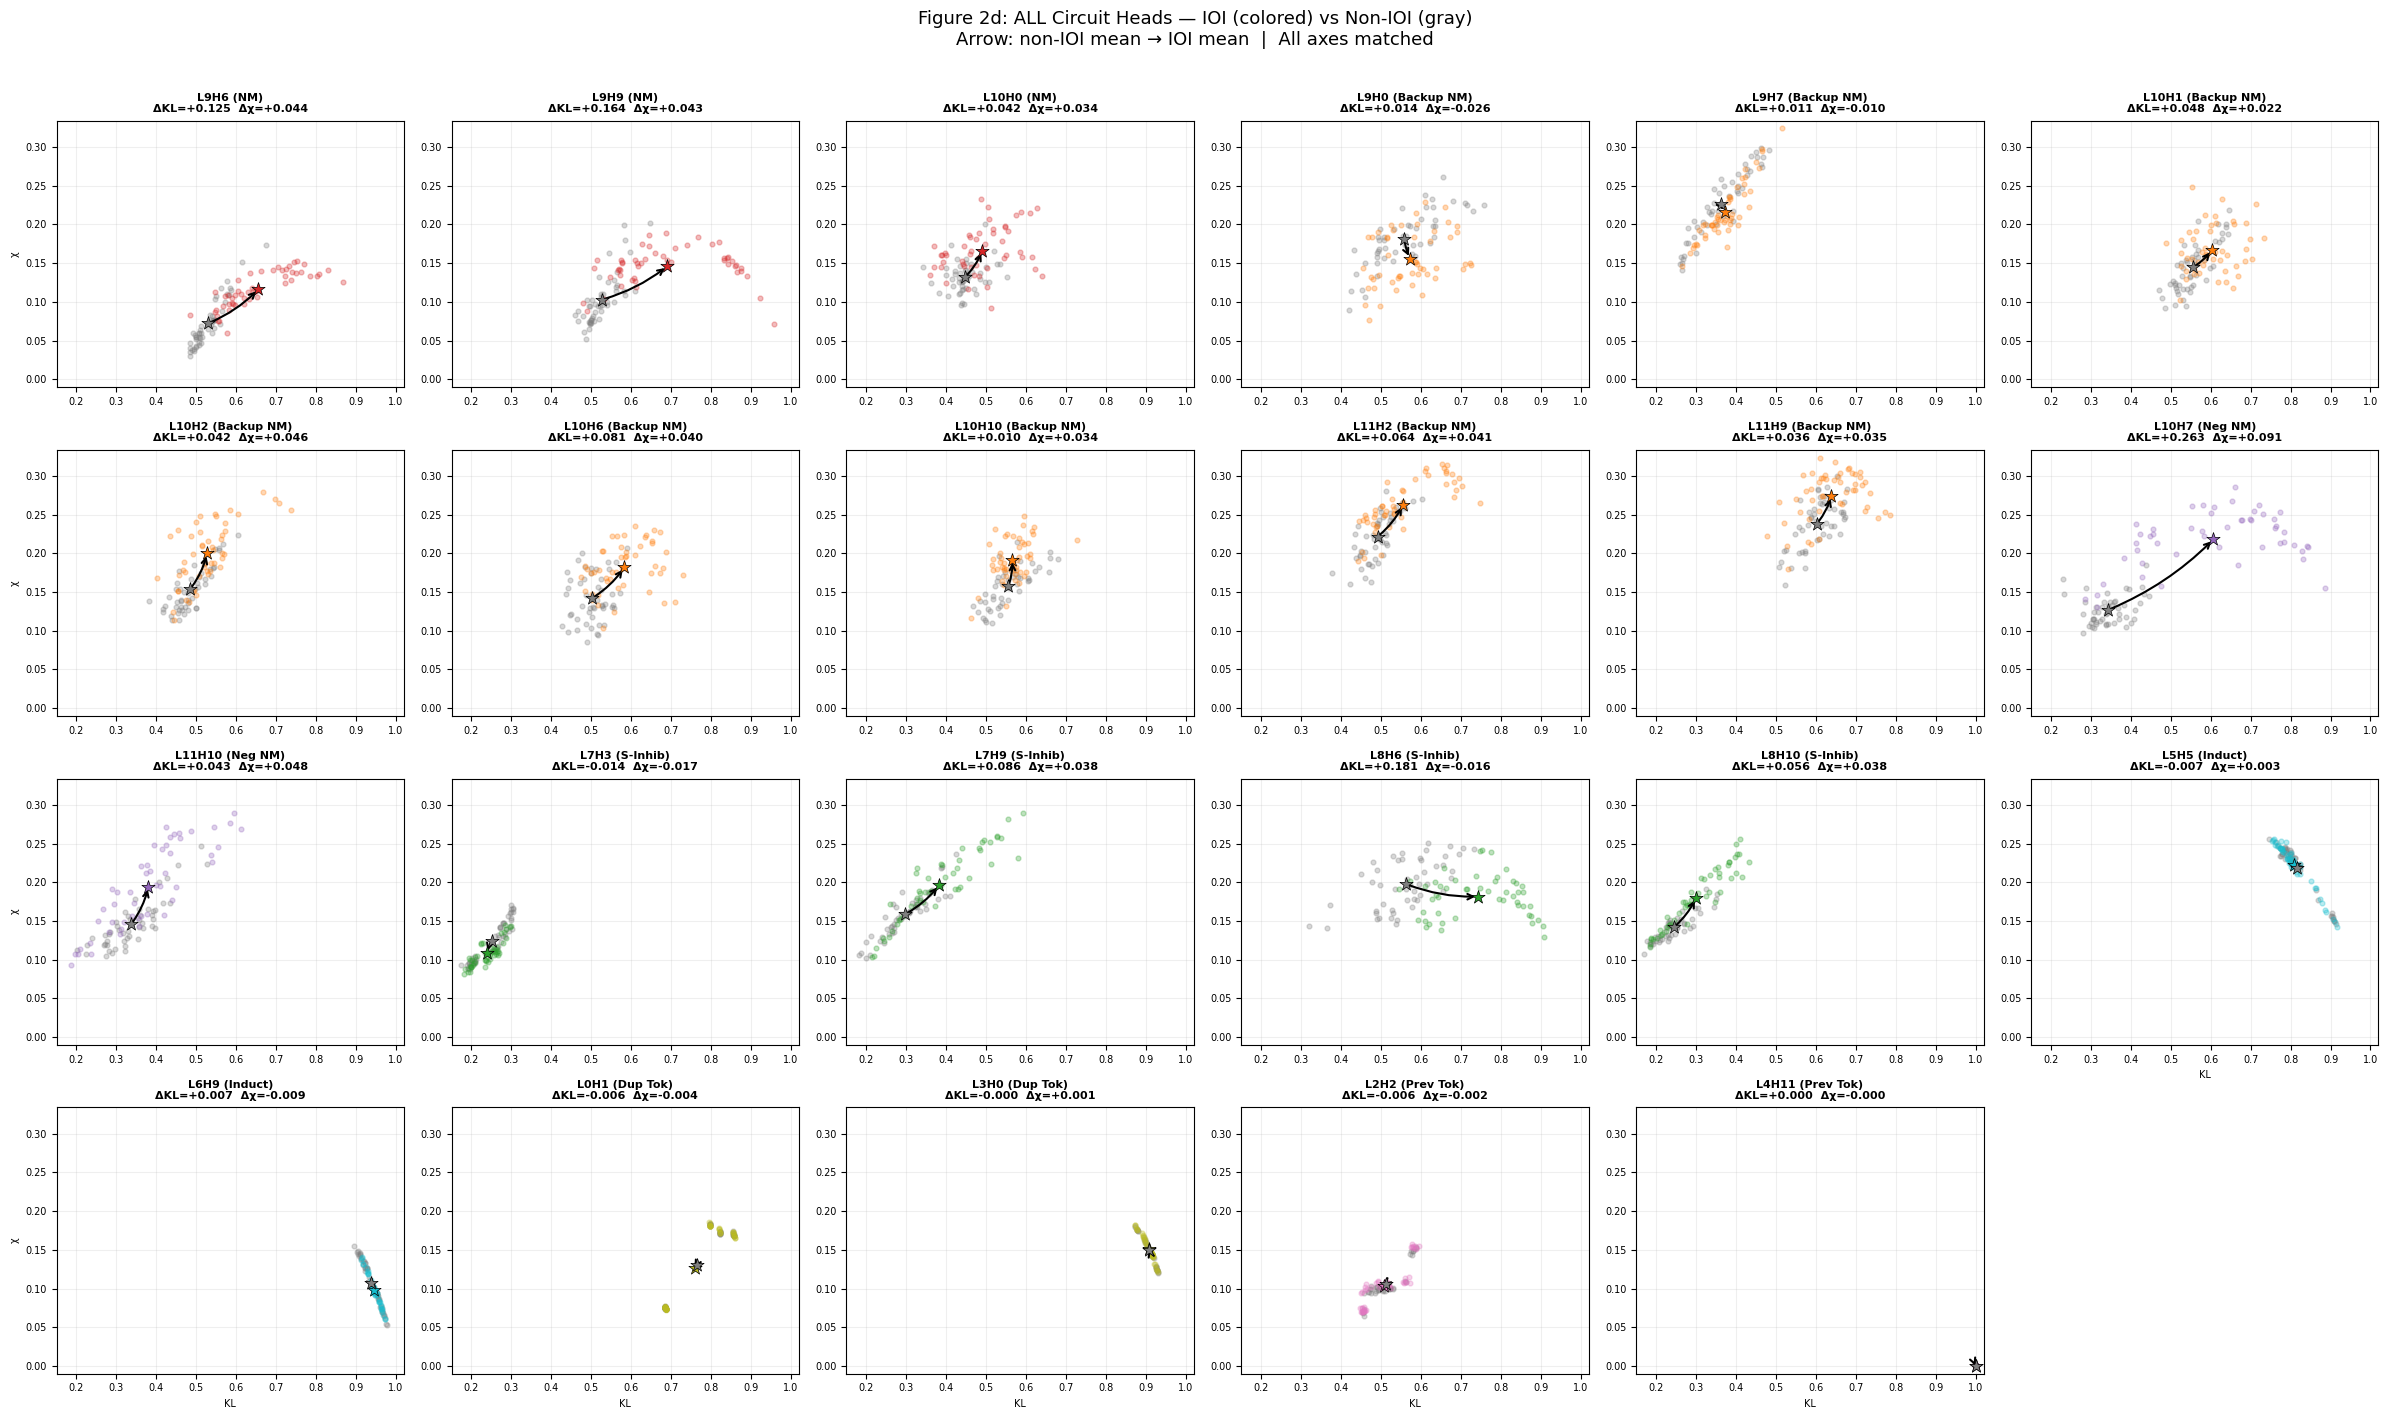


Head       Role                        ΔKL       Δχ   KL_IOI   KL_non    χ_IOI    χ_non
-------------------------------------------------------------------------------------
L9H6       Name Mover             +0.1252 +0.0439 0.6556 0.5304 0.1162 0.0723
L9H9       Name Mover             +0.1642 +0.0432 0.6904 0.5262 0.1459 0.1027
L10H0       Name Mover             +0.0424 +0.0340 0.4908 0.4484 0.1663 0.1323
L9H0       Backup Name Mover      +0.0142 -0.0255 0.5731 0.5590 0.1559 0.1814
L9H7       Backup Name Mover      +0.0111 -0.0098 0.3735 0.3624 0.2160 0.2258
L10H1       Backup Name Mover      +0.0476 +0.0222 0.6029 0.5553 0.1669 0.1447
L10H2       Backup Name Mover      +0.0418 +0.0456 0.5275 0.4857 0.1999 0.1543
L10H6       Backup Name Mover      +0.0806 +0.0399 0.5832 0.5026 0.1819 0.1420
L10H10      Backup Name Mover      +0.0102 +0.0343 0.5659 0.5557 0.1918 0.1574
L11H2       Backup Name Mover      +0.0638 +0.0413 0.5561 0.4922 0.2630 0.2217
L11H9       Backup Name Mover      +0.0

In [9]:
# === Figure 2d: ALL circuit heads — active vs inactive grid ===
# Organized by role, shared axis bounds so fingerprints are directly comparable

# Build list: all circuit heads grouped by role
all_circuit_by_role = []
for role, heads in IOI_HEADS.items():
    for (l, h) in heads:
        all_circuit_by_role.append(((l, h), role))

n_total = len(all_circuit_by_role)  # 23
ncols = 6
nrows = int(np.ceil(n_total / ncols))  # 4

# Pre-compute global axis bounds across all circuit heads, both prompt types
all_kl_vals = []
all_chi_vals = []
for (l, h), _ in all_circuit_by_role:
    all_kl_vals.extend(kl_ioi[:, l, h].tolist())
    all_kl_vals.extend(kl_non_ioi[:, l, h].tolist())
    all_chi_vals.extend(var_ioi[:, l, h].tolist())
    all_chi_vals.extend(var_non_ioi[:, l, h].tolist())

kl_lo = min(all_kl_vals) - 0.02
kl_hi = max(all_kl_vals) + 0.02
chi_lo = min(all_chi_vals) - 0.01
chi_hi = max(all_chi_vals) + 0.01

ROLE_COLORS = {
    "Name Mover": "#d62728",
    "Backup Name Mover": "#ff7f0e",
    "Negative Name Mover": "#9467bd",
    "S-Inhibition": "#2ca02c",
    "Induction": "#17becf",
    "Duplicate Token": "#bcbd22",
    "Previous Token": "#e377c2",
}

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.5 * nrows))
axes_flat = axes.flatten()

for idx, ((l, h), role) in enumerate(all_circuit_by_role):
    ax = axes_flat[idx]

    kl_active = kl_ioi[:, l, h]
    var_active = var_ioi[:, l, h]
    kl_inactive = kl_non_ioi[:, l, h]
    var_inactive = var_non_ioi[:, l, h]

    color = ROLE_COLORS[role]

    ax.scatter(kl_inactive, var_inactive, alpha=0.3, s=12, c="#7f7f7f", zorder=2)
    ax.scatter(kl_active, var_active, alpha=0.3, s=12, c=color, zorder=2)

    mean_active = (kl_active.mean(), var_active.mean())
    mean_inactive = (kl_inactive.mean(), var_inactive.mean())

    ax.scatter(*mean_active, s=100, c=color, marker="*",
               edgecolors="black", linewidths=0.5, zorder=4)
    ax.scatter(*mean_inactive, s=100, c="#7f7f7f", marker="*",
               edgecolors="black", linewidths=0.5, zorder=4)

    # Arrow from inactive → active
    ax.annotate("", xy=mean_active, xytext=mean_inactive,
                arrowprops=dict(arrowstyle="->", color="black",
                                lw=1.5, connectionstyle="arc3,rad=0.1"),
                zorder=3)

    dkl = mean_active[0] - mean_inactive[0]
    dchi = mean_active[1] - mean_inactive[1]

    short_role = (role.replace("Backup Name Mover", "Backup NM")
                      .replace("Negative Name Mover", "Neg NM")
                      .replace("Name Mover", "NM")
                      .replace("S-Inhibition", "S-Inhib")
                      .replace("Duplicate Token", "Dup Tok")
                      .replace("Previous Token", "Prev Tok")
                      .replace("Induction", "Induct"))

    ax.set_title(f"L{l}H{h} ({short_role})\n"
                 f"ΔKL={dkl:+.3f}  Δχ={dchi:+.3f}",
                 fontsize=8, fontweight="bold")
    ax.set_xlim(kl_lo, kl_hi)
    ax.set_ylim(chi_lo, chi_hi)
    ax.grid(True, alpha=0.2)
    ax.tick_params(labelsize=7)

# Hide empty subplots
for idx in range(n_total, len(axes_flat)):
    axes_flat[idx].set_visible(False)

# Axis labels on edges only
for i, ax in enumerate(axes_flat[:n_total]):
    row, col = divmod(i, ncols)
    if row == nrows - 1 or i >= n_total - ncols:
        ax.set_xlabel("KL", fontsize=7)
    if col == 0:
        ax.set_ylabel("χ", fontsize=7)

fig.suptitle("Figure 2d: ALL Circuit Heads — IOI (colored) vs Non-IOI (gray)\n"
             "Arrow: non-IOI mean → IOI mean  |  All axes matched",
             fontsize=13, y=1.01)
plt.tight_layout()
plt.savefig("fig2d_all_circuit_heads.png", dpi=300, bbox_inches="tight")
plt.show()

# Print summary table
print(f"\n{'Head':<10} {'Role':<22} {'ΔKL':>8} {'Δχ':>8} {'KL_IOI':>8} {'KL_non':>8} {'χ_IOI':>8} {'χ_non':>8}")
print("-" * 85)
for (l, h), role in all_circuit_by_role:
    kl_a = kl_ioi[:, l, h].mean()
    kl_i = kl_non_ioi[:, l, h].mean()
    chi_a = var_ioi[:, l, h].mean()
    chi_i = var_non_ioi[:, l, h].mean()
    dkl = kl_a - kl_i
    dchi = chi_a - chi_i
    print(f"L{l}H{h:<7} {role:<22} {dkl:+.4f} {dchi:+.4f} {kl_a:.4f} {kl_i:.4f} {chi_a:.4f} {chi_i:.4f}")

## Figure 3: All 144 Heads on IOI Prompts, Colored by Circuit Role

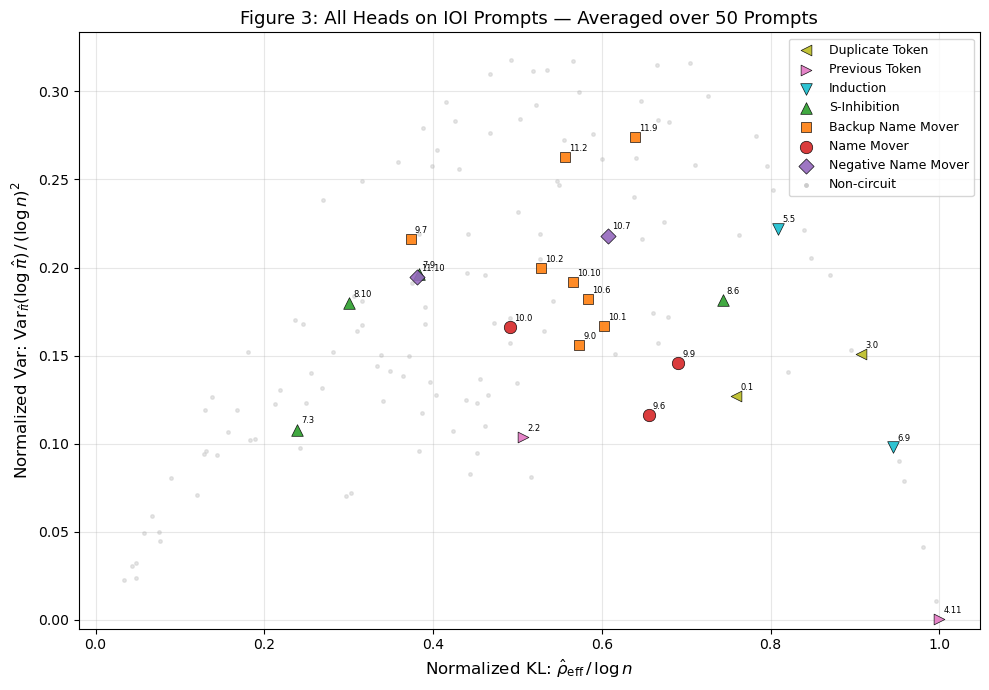

In [10]:
# Average over IOI prompts for each head
kl_mean = kl_ioi.mean(axis=0)   # (n_layers, n_heads)
var_mean = var_ioi.mean(axis=0)

# Color/marker scheme
ROLE_STYLE = {
    "Name Mover":          {"c": "#d62728", "marker": "o", "s": 80},
    "Backup Name Mover":   {"c": "#ff7f0e", "marker": "s", "s": 60},
    "Negative Name Mover": {"c": "#9467bd", "marker": "D", "s": 60},
    "S-Inhibition":        {"c": "#2ca02c", "marker": "^", "s": 70},
    "Induction":           {"c": "#17becf", "marker": "v", "s": 70},
    "Duplicate Token":     {"c": "#bcbd22", "marker": "<", "s": 60},
    "Previous Token":      {"c": "#e377c2", "marker": ">", "s": 60},
    "Non-circuit":         {"c": "#cccccc", "marker": ".", "s": 25},
}

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Plot non-circuit first (background)
for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        role = head_role(layer, head)
        if role == "Non-circuit":
            style = ROLE_STYLE[role]
            ax.scatter(kl_mean[layer, head], var_mean[layer, head],
                       c=style["c"], marker=style["marker"], s=style["s"],
                       alpha=0.5, zorder=1)

# Plot circuit heads on top with labels
plotted_roles = set()
for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        role = head_role(layer, head)
        if role != "Non-circuit":
            style = ROLE_STYLE[role]
            label = role if role not in plotted_roles else None
            plotted_roles.add(role)
            ax.scatter(kl_mean[layer, head], var_mean[layer, head],
                       c=style["c"], marker=style["marker"], s=style["s"],
                       edgecolors="black", linewidths=0.5,
                       alpha=0.9, zorder=2, label=label)
            ax.annotate(f"{layer}.{head}",
                        (kl_mean[layer, head], var_mean[layer, head]),
                        fontsize=6, ha="left", va="bottom",
                        xytext=(3, 3), textcoords="offset points")

# Add non-circuit to legend
ax.scatter([], [], c="#cccccc", marker=".", s=25, label="Non-circuit")

ax.set_xlabel(r"Normalized KL: $\hat{\rho}_{\mathrm{eff}} \,/\, \log n$", fontsize=12)
ax.set_ylabel(r"Normalized Var: $\mathrm{Var}_{\hat{\pi}}(\log \hat{\pi}) \,/\, (\log n)^2$", fontsize=12)
ax.set_title("Figure 3: All Heads on IOI Prompts — Averaged over 50 Prompts", fontsize=13)
ax.legend(fontsize=9, loc="upper right")
ax.set_xlim(left=-0.02)
ax.set_ylim(bottom=-0.005)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("fig3_all_heads_ioi.png", dpi=150, bbox_inches="tight")
plt.show()

## Summary Statistics

## Exploration: Is χ redundant with KL? And does ⟨z⟩ do better?

Check (1) correlation between KL and χ across heads/prompts, and (2) whether excess expected score ⟨z⟩_π − ⟨z⟩_u provides an independent second axis.

In [11]:
def compute_all_diagnostics(model, prompts):
    """
    Compute KL, chi (Var), and excess expected score for all heads.
    Returns arrays of shape (n_prompts, n_layers, n_heads).
    """
    n_layers = model.cfg.n_layers
    n_heads = model.cfg.n_heads
    n_prompts = len(prompts)

    kl_all = np.zeros((n_prompts, n_layers, n_heads))
    chi_all = np.zeros((n_prompts, n_layers, n_heads))
    ez_excess_all = np.zeros((n_prompts, n_layers, n_heads))

    for p_idx, prompt in enumerate(prompts):
        tokens = model.to_tokens(prompt)
        _, cache = model.run_with_cache(tokens)

        seq_len = tokens.shape[1]
        log_n = np.log(seq_len)

        for layer in range(n_layers):
            # Attention weights: (1, n_heads, seq, seq)
            pi = cache["pattern", layer][0, :, -1, :]  # (n_heads, seq_len)

            # Raw scores (pre-softmax): TransformerLens stores "attn_scores"
            # shape: (1, n_heads, seq, seq)
            z = cache["attn_scores", layer][0, :, -1, :]  # (n_heads, seq_len)

            log_pi = torch.log(pi + 1e-12)

            # KL = log n - H(pi), normalized
            entropy = -(pi * log_pi).sum(dim=-1)
            kl_norm = (log_n - entropy.cpu().numpy()) / log_n

            # chi = Var_pi(log pi), normalized
            mean_log_pi = (pi * log_pi).sum(dim=-1, keepdim=True)
            var_log_pi = (pi * (log_pi - mean_log_pi) ** 2).sum(dim=-1)
            chi_norm = var_log_pi.cpu().numpy() / (log_n ** 2)

            # Excess expected score: <z>_pi - <z>_u
            ez_pi = (pi * z).sum(dim=-1)          # (n_heads,)
            ez_u = z.mean(dim=-1)                  # (n_heads,)
            ez_excess = (ez_pi - ez_u).cpu().numpy()

            kl_all[p_idx, layer, :] = kl_norm
            chi_all[p_idx, layer, :] = chi_norm
            ez_excess_all[p_idx, layer, :] = ez_excess

    return kl_all, chi_all, ez_excess_all


print("Computing full diagnostics on IOI prompts...")
kl_ioi_full, chi_ioi, ez_ioi = compute_all_diagnostics(model, ioi_prompts)
print("Computing full diagnostics on non-IOI prompts...")
kl_nonioi_full, chi_nonioi, ez_nonioi = compute_all_diagnostics(model, non_ioi_prompts)
print("Done!")

Computing full diagnostics on IOI prompts...


Computing full diagnostics on non-IOI prompts...


Done!


In [12]:
# === Part 1: KL vs chi correlation ===
# Average over IOI prompts per head, then flatten
kl_flat = kl_ioi_full.mean(axis=0).flatten()
chi_flat = chi_ioi.mean(axis=0).flatten()
ez_flat = ez_ioi.mean(axis=0).flatten()

corr_kl_chi = np.corrcoef(kl_flat, chi_flat)[0, 1]
corr_kl_ez = np.corrcoef(kl_flat, ez_flat)[0, 1]
corr_chi_ez = np.corrcoef(chi_flat, ez_flat)[0, 1]

print("=== Correlations (averaged over IOI prompts, all 144 heads) ===")
print(f"  corr(KL, χ)      = {corr_kl_chi:.3f}")
print(f"  corr(KL, ⟨z⟩_ex) = {corr_kl_ez:.3f}")
print(f"  corr(χ,  ⟨z⟩_ex) = {corr_chi_ez:.3f}")

# Also check per-prompt (not averaged): flatten everything
kl_all_flat = kl_ioi_full.flatten()
chi_all_flat = chi_ioi.flatten()
ez_all_flat = ez_ioi.flatten()

corr_kl_chi_pp = np.corrcoef(kl_all_flat, chi_all_flat)[0, 1]
corr_kl_ez_pp = np.corrcoef(kl_all_flat, ez_all_flat)[0, 1]

print(f"\n=== Per-prompt correlations (all 144 heads × 50 prompts = 7200 points) ===")
print(f"  corr(KL, χ)      = {corr_kl_chi_pp:.3f}")
print(f"  corr(KL, ⟨z⟩_ex) = {corr_kl_ez_pp:.3f}")

=== Correlations (averaged over IOI prompts, all 144 heads) ===
  corr(KL, χ)      = 0.339
  corr(KL, ⟨z⟩_ex) = 0.708
  corr(χ,  ⟨z⟩_ex) = -0.115

=== Per-prompt correlations (all 144 heads × 50 prompts = 7200 points) ===
  corr(KL, χ)      = 0.352
  corr(KL, ⟨z⟩_ex) = 0.707


=== Is Δχ redundant with ΔKL? ===

Correlations:
  corr(ΔKL, Δχ) — all 144 heads:    r = 0.695
  corr(ΔKL, Δχ) — circuit (n=23):    r = 0.604
  corr(ΔKL, Δχ) — non-circuit (n=121): r = 0.651
  corr(|ΔKL|, |Δχ|) — all 144:       r = 0.756
  corr(|ΔKL|, |Δχ|) — circuit (n=23): r = 0.720

For comparison (levels, not deltas):
  corr(KL, χ) on IOI prompts:         r = 0.339


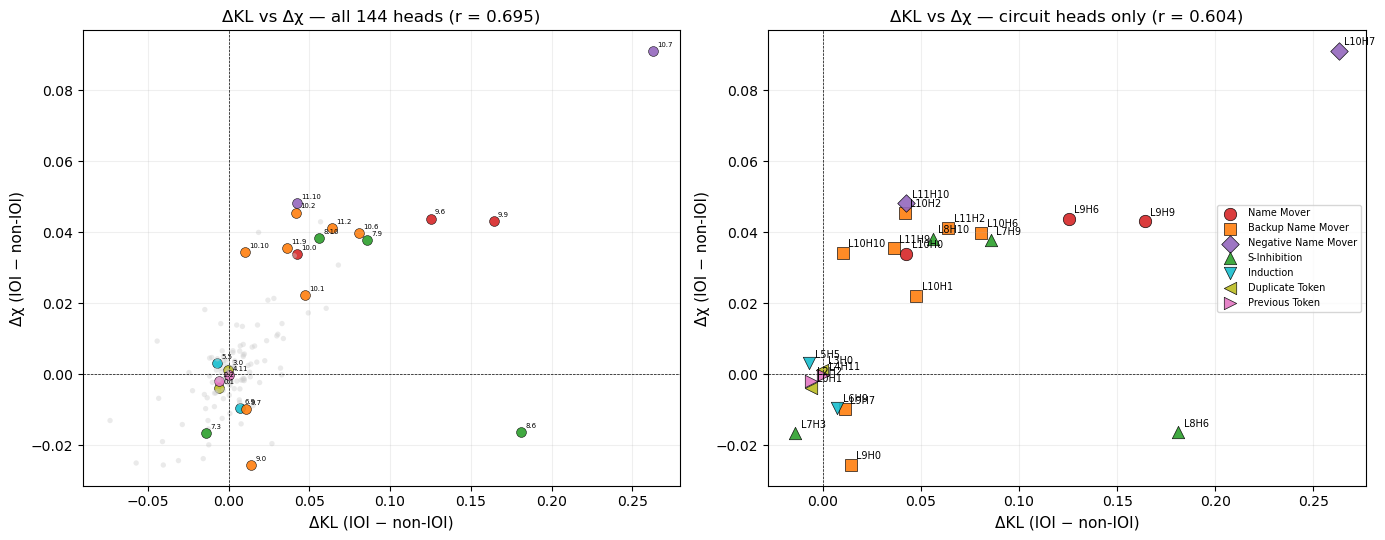


Decoupled heads (|ΔKL| < 0.05, |Δχ| > 0.03):
Head         Role                        ΔKL       Δχ   KL_IOI   KL_non    χ_IOI    χ_non
------------------------------------------------------------------------------------------
L10H0       Name Mover             +0.0424 +0.0340 0.4908 0.4484 0.1663 0.1323
L10H2       Backup Name Mover      +0.0418 +0.0456 0.5275 0.4857 0.1999 0.1543
L10H10      Backup Name Mover      +0.0102 +0.0343 0.5659 0.5557 0.1918 0.1574
L11H1       Non-circuit            +0.0407 +0.0334 0.3065 0.2658 0.1838 0.1504
L11H6       Non-circuit            +0.0186 +0.0400 0.5463 0.5277 0.2494 0.2094
L11H9       Backup Name Mover      +0.0361 +0.0355 0.6393 0.6031 0.2740 0.2385
L11H10      Negative Name Mover    +0.0426 +0.0483 0.3806 0.3380 0.1944 0.1462


In [13]:
# === Is Δχ redundant with ΔKL? ===
# Compute deltas
delta_kl = kl_ioi_full.mean(axis=0) - kl_nonioi_full.mean(axis=0)  # (12, 12)
delta_chi = chi_ioi.mean(axis=0) - chi_nonioi.mean(axis=0)

kl_ioi_mean = kl_ioi_full.mean(axis=0)
kl_nonioi_mean = kl_nonioi_full.mean(axis=0)
chi_ioi_mean = chi_ioi.mean(axis=0)
chi_nonioi_mean = chi_nonioi.mean(axis=0)

# Flatten for correlations
dkl_flat = delta_kl.flatten()
dchi_flat = delta_chi.flatten()

# 1) All 144 heads
r_all = np.corrcoef(dkl_flat, dchi_flat)[0, 1]

# 2) Circuit heads only
dkl_circuit = np.array([delta_kl[l, h] for l, h in ALL_CIRCUIT_HEADS])
dchi_circuit = np.array([delta_chi[l, h] for l, h in ALL_CIRCUIT_HEADS])
r_circuit = np.corrcoef(dkl_circuit, dchi_circuit)[0, 1]

# 3) Non-circuit heads only
dkl_noncircuit = np.array([delta_kl[l, h] for l in range(12) for h in range(12)
                            if (l, h) not in ALL_CIRCUIT_HEADS])
dchi_noncircuit = np.array([delta_chi[l, h] for l in range(12) for h in range(12)
                             if (l, h) not in ALL_CIRCUIT_HEADS])
r_noncircuit = np.corrcoef(dkl_noncircuit, dchi_noncircuit)[0, 1]

# 4) KL levels (not deltas) on IOI prompts — for comparison
kl_ioi_flat = kl_ioi_mean.flatten()
chi_ioi_flat = chi_ioi_mean.flatten()
r_levels = np.corrcoef(kl_ioi_flat, chi_ioi_flat)[0, 1]

# 5) |ΔKL| vs |Δχ| (absolute magnitudes)
r_abs = np.corrcoef(np.abs(dkl_flat), np.abs(dchi_flat))[0, 1]
r_abs_circuit = np.corrcoef(np.abs(dkl_circuit), np.abs(dchi_circuit))[0, 1]

print("=== Is Δχ redundant with ΔKL? ===\n")
print("Correlations:")
print(f"  corr(ΔKL, Δχ) — all 144 heads:    r = {r_all:.3f}")
print(f"  corr(ΔKL, Δχ) — circuit (n=23):    r = {r_circuit:.3f}")
print(f"  corr(ΔKL, Δχ) — non-circuit (n=121): r = {r_noncircuit:.3f}")
print(f"  corr(|ΔKL|, |Δχ|) — all 144:       r = {r_abs:.3f}")
print(f"  corr(|ΔKL|, |Δχ|) — circuit (n=23): r = {r_abs_circuit:.3f}")
print(f"\nFor comparison (levels, not deltas):")
print(f"  corr(KL, χ) on IOI prompts:         r = {r_levels:.3f}")

# Scatter: ΔKL vs Δχ
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Panel 1: all heads
ax = axes[0]
for layer in range(12):
    for head in range(12):
        role = head_role(layer, head)
        c = ROLE_STYLE.get(role, ROLE_STYLE["Non-circuit"])["c"]
        alpha = 0.9 if role != "Non-circuit" else 0.4
        s = 50 if role != "Non-circuit" else 15
        ax.scatter(delta_kl[layer, head], delta_chi[layer, head],
                   c=c, s=s, alpha=alpha, edgecolors="black" if role != "Non-circuit" else "none",
                   linewidths=0.4)
        if role != "Non-circuit":
            ax.annotate(f"{layer}.{head}", (delta_kl[layer, head], delta_chi[layer, head]),
                        fontsize=5, xytext=(3, 3), textcoords="offset points")

ax.axhline(0, color="black", lw=0.5, ls="--")
ax.axvline(0, color="black", lw=0.5, ls="--")
ax.set_xlabel("ΔKL (IOI − non-IOI)", fontsize=11)
ax.set_ylabel("Δχ (IOI − non-IOI)", fontsize=11)
ax.set_title(f"ΔKL vs Δχ — all 144 heads (r = {r_all:.3f})", fontsize=12)
ax.grid(True, alpha=0.2)

# Panel 2: circuit heads only, labeled by role
ax = axes[1]
plotted_roles = set()
for role, heads in IOI_HEADS.items():
    for (l, h) in heads:
        label = role if role not in plotted_roles else None
        plotted_roles.add(role)
        ax.scatter(delta_kl[l, h], delta_chi[l, h],
                   c=ROLE_STYLE[role]["c"], s=80, alpha=0.9,
                   marker=ROLE_STYLE[role]["marker"],
                   edgecolors="black", linewidths=0.5, label=label)
        ax.annotate(f"L{l}H{h}", (delta_kl[l, h], delta_chi[l, h]),
                    fontsize=7, xytext=(4, 4), textcoords="offset points")

ax.axhline(0, color="black", lw=0.5, ls="--")
ax.axvline(0, color="black", lw=0.5, ls="--")
ax.set_xlabel("ΔKL (IOI − non-IOI)", fontsize=11)
ax.set_ylabel("Δχ (IOI − non-IOI)", fontsize=11)
ax.set_title(f"ΔKL vs Δχ — circuit heads only (r = {r_circuit:.3f})", fontsize=12)
ax.legend(fontsize=7, loc="best")
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig("delta_kl_vs_delta_chi.png", dpi=300, bbox_inches="tight")
plt.show()

# Print decoupled heads (|ΔKL| < 0.05 but |Δχ| > 0.03)
print("\nDecoupled heads (|ΔKL| < 0.05, |Δχ| > 0.03):")
print(f"{'Head':<12} {'Role':<22} {'ΔKL':>8} {'Δχ':>8} {'KL_IOI':>8} {'KL_non':>8} {'χ_IOI':>8} {'χ_non':>8}")
print("-" * 90)
for layer in range(12):
    for head in range(12):
        dk = delta_kl[layer, head]
        dc = delta_chi[layer, head]
        if abs(dk) < 0.05 and abs(dc) > 0.03:
            role = head_role(layer, head)
            print(f"L{layer}H{head:<7} {role:<22} {dk:+.4f} {dc:+.4f} "
                  f"{kl_ioi_mean[layer,head]:.4f} {kl_nonioi_mean[layer,head]:.4f} "
                  f"{chi_ioi_mean[layer,head]:.4f} {chi_nonioi_mean[layer,head]:.4f}")

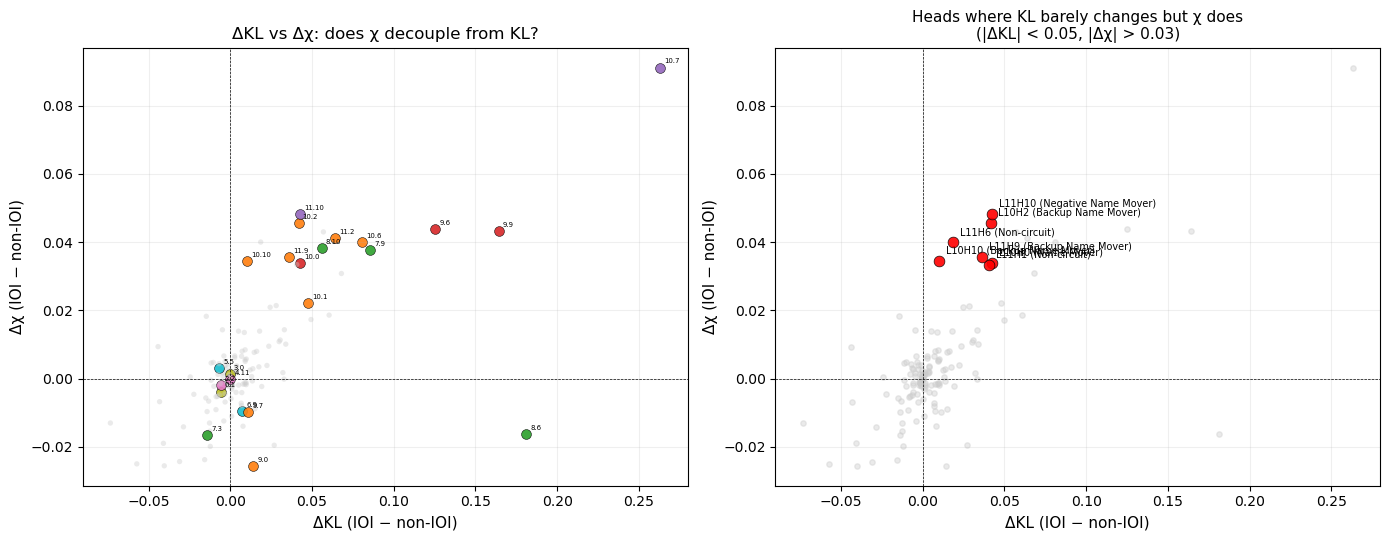


Decoupled heads (|ΔKL| < 0.05, |Δχ| > 0.03):
Head         Role                        ΔKL       Δχ   KL_IOI   KL_non    χ_IOI    χ_non
------------------------------------------------------------------------------------------
L10H0       Name Mover             +0.0424 +0.0340 0.4908 0.4484 0.1663 0.1323
L10H2       Backup Name Mover      +0.0418 +0.0456 0.5275 0.4857 0.1999 0.1543
L10H10      Backup Name Mover      +0.0102 +0.0343 0.5659 0.5557 0.1918 0.1574
L11H1       Non-circuit            +0.0407 +0.0334 0.3065 0.2658 0.1838 0.1504
L11H6       Non-circuit            +0.0186 +0.0400 0.5463 0.5277 0.2494 0.2094
L11H9       Backup Name Mover      +0.0361 +0.0355 0.6393 0.6031 0.2740 0.2385
L11H10      Negative Name Mover    +0.0426 +0.0483 0.3806 0.3380 0.1944 0.1462


In [14]:
# For each head: compute mean KL and chi on IOI vs non-IOI, then deltas
delta_kl = kl_ioi_full.mean(axis=0) - kl_nonioi_full.mean(axis=0)  # (12, 12)
delta_chi = chi_ioi.mean(axis=0) - chi_nonioi.mean(axis=0)

kl_ioi_mean = kl_ioi_full.mean(axis=0)
kl_nonioi_mean = kl_nonioi_full.mean(axis=0)
chi_ioi_mean = chi_ioi.mean(axis=0)
chi_nonioi_mean = chi_nonioi.mean(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Panel 1: ΔKL vs Δχ for all heads
ax = axes[0]
for layer in range(12):
    for head in range(12):
        role = head_role(layer, head)
        c = ROLE_STYLE.get(role, ROLE_STYLE["Non-circuit"])["c"]
        alpha = 0.9 if role != "Non-circuit" else 0.4
        s = 50 if role != "Non-circuit" else 15
        ax.scatter(delta_kl[layer, head], delta_chi[layer, head],
                   c=c, s=s, alpha=alpha, edgecolors="black" if role != "Non-circuit" else "none",
                   linewidths=0.4)
        if role != "Non-circuit":
            ax.annotate(f"{layer}.{head}", (delta_kl[layer, head], delta_chi[layer, head]),
                        fontsize=5, xytext=(3, 3), textcoords="offset points")

ax.axhline(0, color="black", lw=0.5, ls="--")
ax.axvline(0, color="black", lw=0.5, ls="--")
ax.set_xlabel("ΔKL (IOI − non-IOI)", fontsize=11)
ax.set_ylabel("Δχ (IOI − non-IOI)", fontsize=11)
ax.set_title("ΔKL vs Δχ: does χ decouple from KL?", fontsize=12)
ax.grid(True, alpha=0.2)

# Panel 2: Highlight heads where |ΔKL| < 0.05 but |Δχ| > 0.03
# (KL barely changes, chi changes meaningfully)
ax = axes[1]
for layer in range(12):
    for head in range(12):
        dk = delta_kl[layer, head]
        dc = delta_chi[layer, head]
        role = head_role(layer, head)

        is_decoupled = abs(dk) < 0.05 and abs(dc) > 0.03
        if is_decoupled:
            ax.scatter(dk, dc, c="red", s=60, alpha=0.9,
                       edgecolors="black", linewidths=0.5, zorder=3)
            ax.annotate(f"L{layer}H{head} ({role})",
                        (dk, dc), fontsize=7, xytext=(5, 5),
                        textcoords="offset points")
        else:
            ax.scatter(dk, dc, c="#cccccc", s=15, alpha=0.4, zorder=1)

ax.axhline(0, color="black", lw=0.5, ls="--")
ax.axvline(0, color="black", lw=0.5, ls="--")
ax.set_xlabel("ΔKL (IOI − non-IOI)", fontsize=11)
ax.set_ylabel("Δχ (IOI − non-IOI)", fontsize=11)
ax.set_title("Heads where KL barely changes but χ does\n(|ΔKL| < 0.05, |Δχ| > 0.03)", fontsize=11)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig("delta_kl_vs_delta_chi.png", dpi=150, bbox_inches="tight")
plt.show()

# Print the decoupled heads
print("\nDecoupled heads (|ΔKL| < 0.05, |Δχ| > 0.03):")
print(f"{'Head':<12} {'Role':<22} {'ΔKL':>8} {'Δχ':>8} {'KL_IOI':>8} {'KL_non':>8} {'χ_IOI':>8} {'χ_non':>8}")
print("-" * 90)
for layer in range(12):
    for head in range(12):
        dk = delta_kl[layer, head]
        dc = delta_chi[layer, head]
        if abs(dk) < 0.05 and abs(dc) > 0.03:
            role = head_role(layer, head)
            print(f"L{layer}H{head:<7} {role:<22} {dk:+.4f} {dc:+.4f} "
                  f"{kl_ioi_mean[layer,head]:.4f} {kl_nonioi_mean[layer,head]:.4f} "
                  f"{chi_ioi_mean[layer,head]:.4f} {chi_nonioi_mean[layer,head]:.4f}")

## Where do non-activated circuit heads actually attend?

Verify directly: when circuit heads have high KL on non-IOI prompts, what tokens are they peaked on?

In [15]:
# For a selection of circuit heads, look at where they attend on non-IOI prompts
# For each head & prompt: find the argmax token and the top-3 tokens with their weights

HEADS_TO_INSPECT = [
    ((9, 9),  "Name Mover"),
    ((9, 6),  "Name Mover"),
    ((7, 3),  "S-Inhibition"),
    ((5, 5),  "Induction"),
    ((3, 0),  "Duplicate Token"),
    ((4, 11), "Previous Token"),
]

print("=== Non-IOI prompts: where do circuit heads attend? ===\n")

for (l, h), role in HEADS_TO_INSPECT:
    # Collect argmax position stats across all non-IOI prompts
    argmax_positions = []  # relative position (0 = first token, -1 = last)
    argmax_tokens = []
    max_weights = []

    for prompt in non_ioi_prompts[:20]:  # first 20 for readability
        tokens = model.to_tokens(prompt)
        _, cache = model.run_with_cache(tokens)
        pi = cache["pattern", l][0, h, -1, :]  # (seq_len,)
        seq_len = tokens.shape[1]

        # Top-3 positions
        topk = torch.topk(pi, k=min(3, seq_len))
        top_positions = topk.indices.cpu().numpy()
        top_weights = topk.values.cpu().numpy()

        # Decode tokens at those positions
        token_strs = [model.to_string(tokens[0, pos:pos+1]) for pos in top_positions]

        argmax_positions.append(top_positions[0])
        argmax_tokens.append(token_strs[0])
        max_weights.append(top_weights[0])

    # Summary
    argmax_positions = np.array(argmax_positions)
    max_weights = np.array(max_weights)

    # Count how often argmax is position 0 (BOS)
    bos_frac = (argmax_positions == 0).mean()
    # Count how often argmax is the last or second-to-last position
    # (we look at attention FROM the last token, so prev = seq_len - 2)

    print(f"L{l}H{h} ({role}):")
    print(f"  Argmax is BOS (pos 0):  {bos_frac:.0%}")
    print(f"  Mean max weight:        {max_weights.mean():.3f} ± {max_weights.std():.3f}")
    print(f"  Most common argmax tokens: ", end="")

    from collections import Counter
    tok_counts = Counter(argmax_tokens)
    for tok, cnt in tok_counts.most_common(5):
        print(f"'{tok.strip()}'({cnt})", end="  ")
    print(f"\n  Argmax positions: {argmax_positions.tolist()}")
    print()

=== Non-IOI prompts: where do circuit heads attend? ===



L9H9 (Name Mover):
  Argmax is BOS (pos 0):  80%
  Mean max weight:        0.459 ± 0.077
  Most common argmax tokens: '<|endoftext|>'(16)  'Sarah'(1)  'David'(1)  'Emma'(1)  'Alice'(1)  
  Argmax positions: [2, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]



L9H6 (Name Mover):
  Argmax is BOS (pos 0):  80%
  Mean max weight:        0.455 ± 0.096
  Most common argmax tokens: '<|endoftext|>'(16)  'Emma'(2)  'Kate'(1)  'Alice'(1)  
  Argmax positions: [0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]



L7H3 (S-Inhibition):
  Argmax is BOS (pos 0):  5%
  Mean max weight:        0.339 ± 0.067
  Most common argmax tokens: 'gave'(7)  'showed'(6)  'handed'(3)  'passed'(2)  'offered'(1)  
  Argmax positions: [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 0, 11]



L5H5 (Induction):
  Argmax is BOS (pos 0):  100%
  Mean max weight:        0.904 ± 0.023
  Most common argmax tokens: '<|endoftext|>'(20)  
  Argmax positions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



L3H0 (Duplicate Token):
  Argmax is BOS (pos 0):  100%
  Mean max weight:        0.961 ± 0.009
  Most common argmax tokens: '<|endoftext|>'(20)  
  Argmax positions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



L4H11 (Previous Token):
  Argmax is BOS (pos 0):  0%
  Mean max weight:        1.000 ± 0.000
  Most common argmax tokens: 'book'(6)  'drink'(5)  'ball'(3)  'note'(2)  'gift'(2)  
  Argmax positions: [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]



## Formal test: is |ΔKL| larger for circuit heads?

=== |ΔKL| comparison: circuit vs non-circuit heads ===
  Circuit heads (n=23):     mean |ΔKL| = 0.0568 ± 0.0663
  Non-circuit heads (n=121): mean |ΔKL| = 0.0134 ± 0.0154
  Mann-Whitney U (circuit > non-circuit): U = 2049, p = 0.0002

=== |Δχ| comparison: circuit vs non-circuit heads ===
  Circuit heads:     mean |Δχ| = 0.0280 ± 0.0210
  Non-circuit heads: mean |Δχ| = 0.0075 ± 0.0083
  Mann-Whitney U (circuit > non-circuit): U = 2219, p = 0.0000


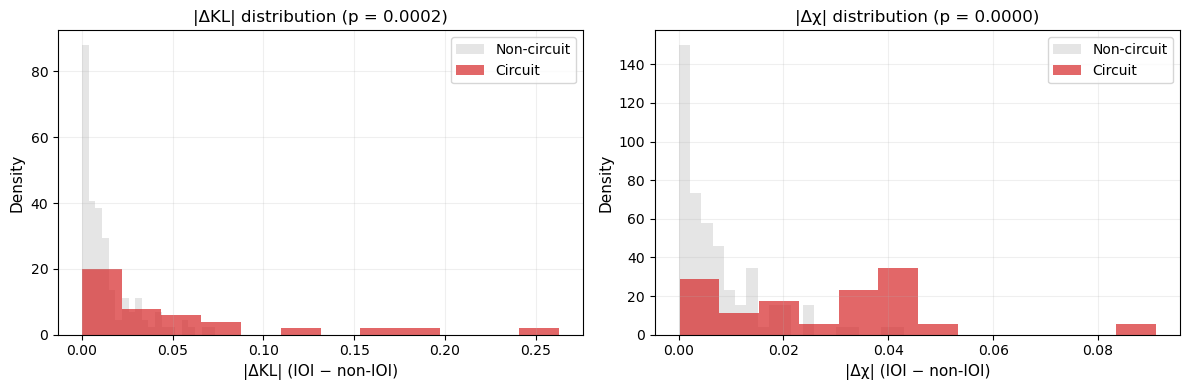

In [16]:
from scipy import stats

abs_dkl_circuit = []
abs_dkl_noncircuit = []

for layer in range(12):
    for head in range(12):
        val = abs(delta_kl[layer, head])
        if (layer, head) in ALL_CIRCUIT_HEADS:
            abs_dkl_circuit.append(val)
        else:
            abs_dkl_noncircuit.append(val)

abs_dkl_circuit = np.array(abs_dkl_circuit)
abs_dkl_noncircuit = np.array(abs_dkl_noncircuit)

# Mann-Whitney U test (non-parametric, doesn't assume normality)
u_stat, p_val = stats.mannwhitneyu(abs_dkl_circuit, abs_dkl_noncircuit, alternative='greater')

print(f"=== |ΔKL| comparison: circuit vs non-circuit heads ===")
print(f"  Circuit heads (n={len(abs_dkl_circuit)}):     mean |ΔKL| = {abs_dkl_circuit.mean():.4f} ± {abs_dkl_circuit.std():.4f}")
print(f"  Non-circuit heads (n={len(abs_dkl_noncircuit)}): mean |ΔKL| = {abs_dkl_noncircuit.mean():.4f} ± {abs_dkl_noncircuit.std():.4f}")
print(f"  Mann-Whitney U (circuit > non-circuit): U = {u_stat:.0f}, p = {p_val:.4f}")
print()

# Also do the same for |Δχ|
abs_dchi_circuit = np.array([abs(delta_chi[l, h]) for l, h in ALL_CIRCUIT_HEADS])
abs_dchi_noncircuit = np.array([abs(delta_chi[l, h]) for l in range(12) for h in range(12)
                                 if (l, h) not in ALL_CIRCUIT_HEADS])

u_stat2, p_val2 = stats.mannwhitneyu(abs_dchi_circuit, abs_dchi_noncircuit, alternative='greater')

print(f"=== |Δχ| comparison: circuit vs non-circuit heads ===")
print(f"  Circuit heads:     mean |Δχ| = {abs_dchi_circuit.mean():.4f} ± {abs_dchi_circuit.std():.4f}")
print(f"  Non-circuit heads: mean |Δχ| = {abs_dchi_noncircuit.mean():.4f} ± {abs_dchi_noncircuit.std():.4f}")
print(f"  Mann-Whitney U (circuit > non-circuit): U = {u_stat2:.0f}, p = {p_val2:.4f}")

# Histogram
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.hist(abs_dkl_noncircuit, bins=20, alpha=0.5, color="#cccccc", label="Non-circuit", density=True)
ax.hist(abs_dkl_circuit, bins=12, alpha=0.7, color="#d62728", label="Circuit", density=True)
ax.set_xlabel("|ΔKL| (IOI − non-IOI)", fontsize=11)
ax.set_ylabel("Density", fontsize=11)
ax.set_title(f"|ΔKL| distribution (p = {p_val:.4f})", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.2)

ax = axes[1]
ax.hist(abs_dchi_noncircuit, bins=20, alpha=0.5, color="#cccccc", label="Non-circuit", density=True)
ax.hist(abs_dchi_circuit, bins=12, alpha=0.7, color="#d62728", label="Circuit", density=True)
ax.set_xlabel("|Δχ| (IOI − non-IOI)", fontsize=11)
ax.set_ylabel("Density", fontsize=11)
ax.set_title(f"|Δχ| distribution (p = {p_val2:.4f})", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig("delta_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

## Context length confound check

Do IOI and non-IOI prompts have different token lengths? If so, normalization by log n may not fully account for it.

=== Token lengths ===
  IOI:     mean = 15.0, std = 0.0, range = [15, 15]
  Non-IOI: mean = 15.0, std = 0.0, range = [15, 15]
  Mann-Whitney U (two-sided): p = 1.0000


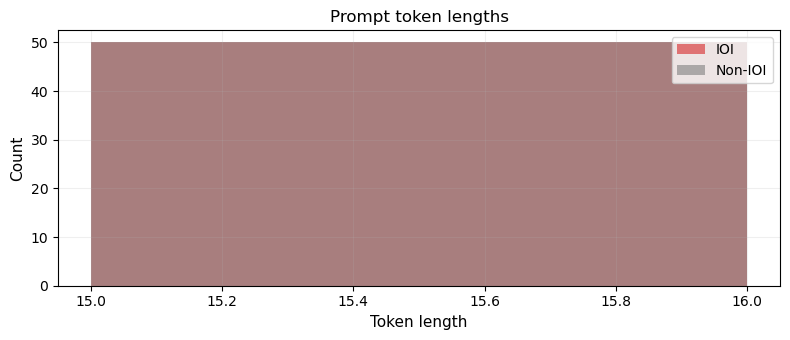

In [17]:
ioi_lengths = [model.to_tokens(p).shape[1] for p in ioi_prompts]
non_ioi_lengths = [model.to_tokens(p).shape[1] for p in non_ioi_prompts]

print(f"=== Token lengths ===")
print(f"  IOI:     mean = {np.mean(ioi_lengths):.1f}, std = {np.std(ioi_lengths):.1f}, "
      f"range = [{min(ioi_lengths)}, {max(ioi_lengths)}]")
print(f"  Non-IOI: mean = {np.mean(non_ioi_lengths):.1f}, std = {np.std(non_ioi_lengths):.1f}, "
      f"range = [{min(non_ioi_lengths)}, {max(non_ioi_lengths)}]")

u_len, p_len = stats.mannwhitneyu(ioi_lengths, non_ioi_lengths, alternative='two-sided')
print(f"  Mann-Whitney U (two-sided): p = {p_len:.4f}")

fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.hist(ioi_lengths, bins=range(min(ioi_lengths + non_ioi_lengths),
        max(ioi_lengths + non_ioi_lengths) + 2),
        alpha=0.6, color="#d62728", label="IOI")
ax.hist(non_ioi_lengths, bins=range(min(ioi_lengths + non_ioi_lengths),
        max(ioi_lengths + non_ioi_lengths) + 2),
        alpha=0.6, color="#7f7f7f", label="Non-IOI")
ax.set_xlabel("Token length", fontsize=11)
ax.set_ylabel("Count", fontsize=11)
ax.set_title("Prompt token lengths", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig("prompt_lengths.png", dpi=150, bbox_inches="tight")
plt.show()

## Layer depth confound

Do KL and χ vary systematically with layer depth, independent of circuit role?

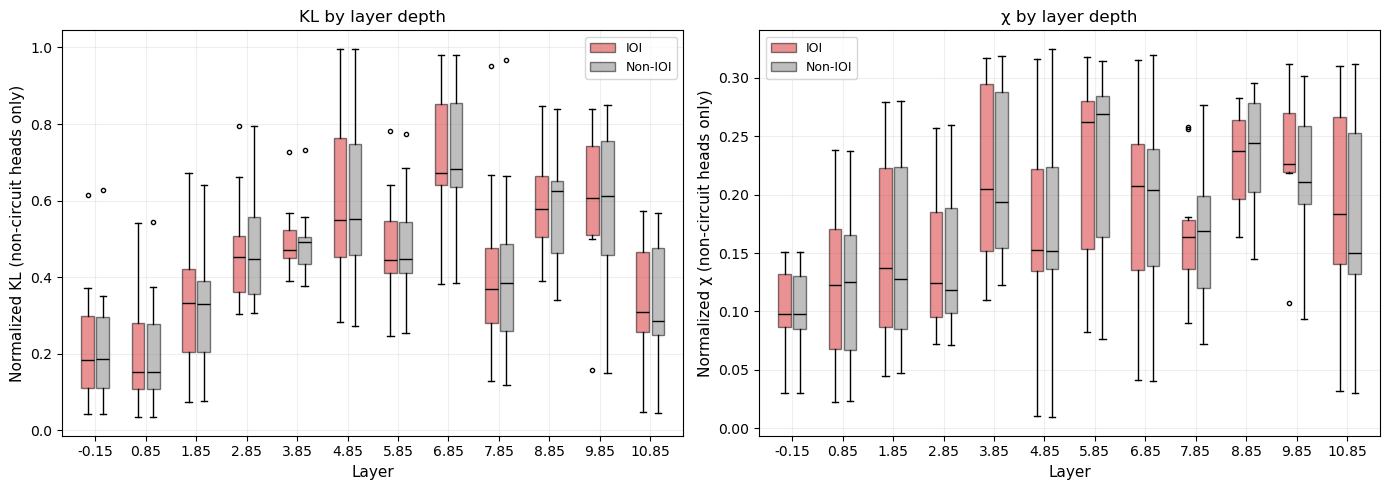


Correlation with layer depth (non-circuit heads, IOI prompts):
  corr(layer, KL) = 0.379
  corr(layer, χ)  = 0.384


In [18]:
# For each layer, compute mean KL and chi across all heads (non-circuit only, to avoid
# circuit heads biasing the layer-level stats)
kl_by_layer_ioi = []
chi_by_layer_ioi = []
kl_by_layer_nonioi = []
chi_by_layer_nonioi = []

for layer in range(12):
    non_circ_heads = [h for h in range(12) if (layer, h) not in ALL_CIRCUIT_HEADS]
    kl_by_layer_ioi.append([kl_ioi_full[:, layer, h].mean() for h in non_circ_heads])
    chi_by_layer_ioi.append([chi_ioi[:, layer, h].mean() for h in non_circ_heads])
    kl_by_layer_nonioi.append([kl_nonioi_full[:, layer, h].mean() for h in non_circ_heads])
    chi_by_layer_nonioi.append([chi_nonioi[:, layer, h].mean() for h in non_circ_heads])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KL by layer
ax = axes[0]
bp1 = ax.boxplot(kl_by_layer_ioi, positions=np.arange(12) - 0.15, widths=0.25,
                  patch_artist=True, boxprops=dict(facecolor="#d62728", alpha=0.5),
                  medianprops=dict(color="black"), flierprops=dict(markersize=3))
bp2 = ax.boxplot(kl_by_layer_nonioi, positions=np.arange(12) + 0.15, widths=0.25,
                  patch_artist=True, boxprops=dict(facecolor="#7f7f7f", alpha=0.5),
                  medianprops=dict(color="black"), flierprops=dict(markersize=3))
ax.set_xlabel("Layer", fontsize=11)
ax.set_ylabel("Normalized KL (non-circuit heads only)", fontsize=11)
ax.set_title("KL by layer depth", fontsize=12)
ax.set_xticks(range(12))
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["IOI", "Non-IOI"], fontsize=9)
ax.grid(True, alpha=0.2)

# Chi by layer
ax = axes[1]
bp1 = ax.boxplot(chi_by_layer_ioi, positions=np.arange(12) - 0.15, widths=0.25,
                  patch_artist=True, boxprops=dict(facecolor="#d62728", alpha=0.5),
                  medianprops=dict(color="black"), flierprops=dict(markersize=3))
bp2 = ax.boxplot(chi_by_layer_nonioi, positions=np.arange(12) + 0.15, widths=0.25,
                  patch_artist=True, boxprops=dict(facecolor="#7f7f7f", alpha=0.5),
                  medianprops=dict(color="black"), flierprops=dict(markersize=3))
ax.set_xlabel("Layer", fontsize=11)
ax.set_ylabel("Normalized χ (non-circuit heads only)", fontsize=11)
ax.set_title("χ by layer depth", fontsize=12)
ax.set_xticks(range(12))
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["IOI", "Non-IOI"], fontsize=9)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig("layer_depth.png", dpi=150, bbox_inches="tight")
plt.show()

# Correlation of layer index with mean KL/chi (non-circuit only)
layer_indices = []
kl_vals = []
chi_vals = []
for layer in range(12):
    for h in range(12):
        if (layer, h) not in ALL_CIRCUIT_HEADS:
            layer_indices.append(layer)
            kl_vals.append(kl_ioi_full[:, layer, h].mean())
            chi_vals.append(chi_ioi[:, layer, h].mean())

r_layer_kl = np.corrcoef(layer_indices, kl_vals)[0, 1]
r_layer_chi = np.corrcoef(layer_indices, chi_vals)[0, 1]
print(f"\nCorrelation with layer depth (non-circuit heads, IOI prompts):")
print(f"  corr(layer, KL) = {r_layer_kl:.3f}")
print(f"  corr(layer, χ)  = {r_layer_chi:.3f}")

In [19]:
print("IOI prompt averages by circuit role:")
print(f"{'Role':<25} {'KL (mean±std)':<20} {'Var (mean±std)'}")
print("-" * 65)

for role in list(IOI_HEADS.keys()) + ["Non-circuit"]:
    if role == "Non-circuit":
        heads = [(l, h) for l in range(12) for h in range(12)
                 if (l, h) not in ALL_CIRCUIT_HEADS]
    else:
        heads = IOI_HEADS[role]
    
    kls = [kl_ioi[:, l, h].mean() for l, h in heads]
    vars_ = [var_ioi[:, l, h].mean() for l, h in heads]
    
    print(f"{role:<25} {np.mean(kls):.4f} ± {np.std(kls):.4f}     {np.mean(vars_):.4f} ± {np.std(vars_):.4f}")

IOI prompt averages by circuit role:
Role                      KL (mean±std)        Var (mean±std)
-----------------------------------------------------------------
Name Mover                0.6122 ± 0.0870     0.1428 ± 0.0206
Backup Name Mover         0.5527 ± 0.0744     0.2062 ± 0.0400
Negative Name Mover       0.4937 ± 0.1131     0.2063 ± 0.0119
S-Inhibition              0.4164 ± 0.1954     0.1664 ± 0.0343
Induction                 0.8770 ± 0.0682     0.1602 ± 0.0619
Duplicate Token           0.8332 ± 0.0739     0.1388 ± 0.0120
Previous Token            0.7532 ± 0.2467     0.0521 ± 0.0519
Non-circuit               0.4439 ± 0.2276     0.1748 ± 0.0810
